Text(0.5, 1.0, 'Ground truth')

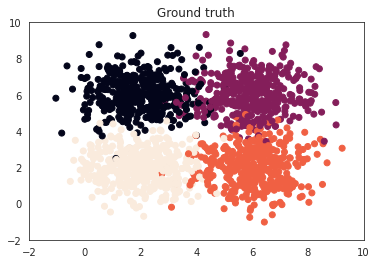

In [334]:
import torch

from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
n_classes = 4
ymin, ymax = -2, 10
xmin, xmax = -2, 10
n_samples = [400 for i in range(n_classes)]
centers = [(2, 6), (6, 6), (6, 2), (2, 2)]
X, y = datasets.make_blobs(n_samples = n_samples, 
                           n_features = 2, centers=centers)
plot_X, plot_y = datasets.make_blobs(n_samples = n_samples,
                                     n_features = 2, centers=centers)
plt.scatter(X[:,0], X[:,1], c=y)
plt.ylim(ymin, ymax)
plt.xlim(ymin, ymax)
plt.title("Ground truth")

In [389]:
# split into training, val, test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                   test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2


(-2.0, 10.0)

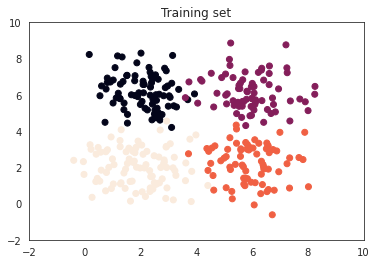

In [390]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.title("Training set")
plt.ylim(ymin, ymax)
plt.xlim(ymin, ymax)

In [421]:
# define and train a model
N, D_in, H1,H2, D_out = 64, 2, 10, 10, n_classes
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),
#    torch.nn.Softmax()
)
features = torch.nn.Sequential(*list(model.children())[:-1])

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = .01
batch_size = 32
epochs = 1000
losses = []
for i in range(epochs):
    t = 0
    while t < len(X_train):

        y_pred = model(torch.Tensor(X_train[t:t+batch_size]))
        loss = loss_fn(y_pred, torch.LongTensor(y_train[t:t+batch_size]))
        losses.append(loss.cpu())
        if t % 100 == 99:
            print(t, loss.item())

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
        t += batch_size

(-2.0, 10.0)

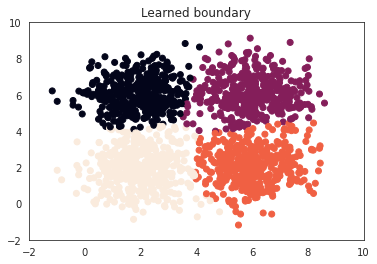

In [422]:
import numpy as np
outputs_plot_X = model(torch.Tensor(plot_X)).detach().cpu().numpy()
plt.scatter(plot_X[:,0], plot_X[:,1], c=np.argmax(outputs_plot_X, axis=1))
plt.title("Learned boundary")
plt.ylim(ymin, ymax)
plt.xlim(ymin, ymax)

# Plot boundary using standard test-time augmentation

In [423]:
# Shift up + shift right + shift left + shift 
shift_amt = 2
def shift_right(shift_amt):
    return lambda x: np.array([x[:,0] + shift_amt, x[:,1]]).T

def shift_left(shift_amt):
    return lambda x: np.array([x[:,0] - shift_amt, x[:,1]]).T

def shift_up(shift_amt):
    return lambda x: np.array([x[:,0], x[:,1] + shift_amt]).T

def shift_down(shift_amt):
    return lambda x: np.array([x[:,0], x[:,1] - shift_amt]).T

transforms = [shift_left(shift_amt), 
             shift_left(shift_amt/2),]

t = 0
examples = plot_X
x_tensor = torch.Tensor(examples)
outputs = [model(x_tensor)]
for tform in transforms:
    x_tform = tform(examples)
    x_tensor = torch.Tensor(x_tform)
    outputs.append(model(x_tensor))

(-2.0, 10.0)

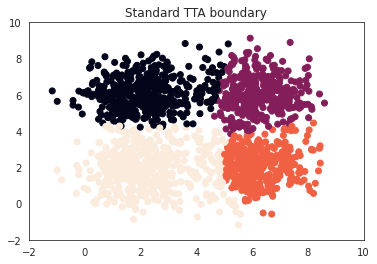

In [424]:
gg = np.array([o.detach().cpu().numpy() for o in outputs])
stta_outputs = np.sum(gg, axis=0)
plt.scatter(plot_X[:,0], plot_X[:,1], c=np.argmax(stta_outputs, axis=1))
plt.title("Standard TTA boundary")
plt.ylim(ymin, ymax)
plt.xlim(ymin, ymax)

In [425]:
examples_and_augs.shape

(3, 32, 4)

In [452]:
# Learn to apply just shift left and just shift up to the learned STTA boundary
import torch.nn.functional as F
from torch import nn
n_augs = len(transforms) + 1
class ImageW(nn.Module):    
    def __init__(self, model, features, n_augs, orig_idx, n_features=10):
        super().__init__()
        self.model = model
        self.features = features
        for param in self.features.parameters():
            param.requires_grad = False
        for param in self.model.parameters():
            param.requires_grad = False
        self.n_augs = n_augs
        self.orig_idx = orig_idx
        n_full = 10
        self.fc3 = nn.Linear(n_features, n_full)
        self.dropout1 = nn.Dropout2d(0.5)
        self.fc4 =  nn.Linear(n_full, n_augs)
        self.sigmoid = torch.nn.Sigmoid()
        self.sm = nn.Softmax(dim=1)
                
    def forward(self, x):
        f = x[self.orig_idx]
        w = self.fc3(f)
        w = F.relu(w)
        w = self.dropout1(w)
        w = self.fc4(w)
        w = self.sm(w)
        
        aug_preds = []
        for i in range(len(x)):
            aug_preds.append(self.model(x[i]))
        
        aug_preds = torch.stack(aug_preds)
        aug_preds = aug_preds.permute(2, 1, 0)
        aug_preds = aug_preds * w
        aug_pred = aug_preds.mean(axis=2)
        return aug_pred.permute(1, 0)
    
    def get_w(self, x):
        orig_image = x[self.orig_idx]
        f = self.model.features(orig_image)

        w = self.fc3(f)
        return  self.sm(w)

w_model = ImageW(model, features, n_augs, 0, 2)
examples = X_val
examples_and_augs = np.array([examples] + \
                                [tform(examples)for tform in transforms])

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(w_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)

learning_rate = .1
batch_size = 32
epochs = 500
losses = []
for i in range(epochs):
    t = 0
    while t < examples_and_augs.shape[1]:
        y_pred = w_model(torch.Tensor(examples_and_augs[:,t:t+batch_size,:]))
        loss = loss_fn(y_pred, torch.LongTensor(y_val[t:t+batch_size]))
    
        losses.append(loss.cpu())
        if t % 100 == 99:
            print(t, loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t += batch_size

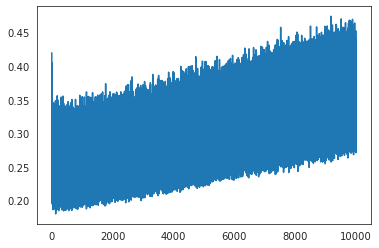

In [453]:
plt.plot(losses)

In [396]:
examples = plot_X
x_tensor = torch.Tensor(examples)
ws = w_model(x_tensor)

outputs = [model(x_tensor)]
for tform in transforms:
    x_tform = tform(examples)
    x_tensor = torch.Tensor(x_tform)
    outputs.append(model(x_tensor))
outputs = np.array([o.detach().cpu().numpy() for o in outputs])
wtta_outputs = ws.detach().cpu().numpy().T * np.transpose(outputs, (2, 0, 1))
wtta_outputs = np.mean(wtta_outputs, axis=1)

(-2.0, 10.0)

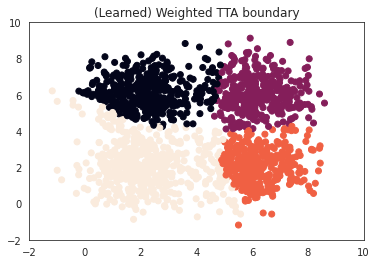

In [397]:
plt.scatter(plot_X[:,0], plot_X[:,1], c=np.argmax(wtta_outputs, axis=0))
plt.title("(Learned) Weighted TTA boundary")
plt.ylim(ymin, ymax)
plt.xlim(ymin, ymax)

(array([ 26., 211., 405., 376., 216., 167., 106.,  59.,  29.,   5.]),
 array([0.15775746, 0.16740707, 0.17705669, 0.18670629, 0.19635591,
        0.20600551, 0.21565512, 0.22530474, 0.23495434, 0.24460396,
        0.25425357], dtype=float32),
 <BarContainer object of 10 artists>)

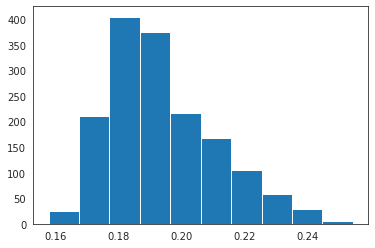

In [367]:
plt.hist(ws.detach().cpu().numpy()[:,2])

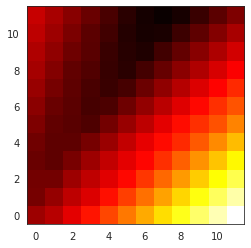

In [380]:

heatmap = np.zeros((12, 12))
for x_val in range(12):
    for y_val in range(12):
        w = w_model(torch.Tensor([[x_val, y_val]]))
        heatmap[int(x_val), int(y_val)] = w.detach().cpu().numpy()[0][0]
plt.imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')

In [ ]:
heatmap[]